## 3D Vision HW 5
Name: Parham Rezaei
STDID : 400108547

* imports

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

* Utils (Functions I use in mainly problem 1 and 2)

In [274]:
def sobel_filter(size=3, d='x'):
    if size == 3:
        if d == 'x':
            return 1/8*np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
        elif d == 'y':
            return 1/8*np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    elif size == 5:
        if d == 'x':
            return 1/256*np.array([[-1,-4,0,4,1],[-4,-16,0,16,4],[-6,-24,0,24,6],[-4,-16,0,16,4],[-1,-4,0,4,1]])
        elif d == 'y':
            return 1/256*np.array([[1,4,6,4,1],[4,16,24,16,4],[0,0,0,0,0],[-4,-16,-24,-16,-4],[-1,-4,-6,-4,-1]])
    
    else :
        raise ValueError('size must be 3 or 5')

def gaussian_filter(size):
    if size == 3:
        return 1/16*np.array([[1,2,1],[2,4,2],[1,2,1]])
    elif size == 5:
        return 1/256*np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])
    else:
        raise ValueError('size must be 3 or 5')
    
def convolve(img, kernel):
    img_height, img_width = img.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = int(kernel_height//2)
    pad_width = int(kernel_width//2)
    padded_img = np.zeros((img_height+2*pad_height, img_width+2*pad_width))
    padded_img[pad_height:pad_height+img_height, pad_width:pad_width+img_width] = img
    convolved_img = np.zeros((img_height, img_width))
    for i in range(img_height):
        for j in range(img_width):
            convolved_img[i,j] = np.sum(np.multiply(padded_img[i:i+kernel_height, j:j+kernel_width], kernel))

    return convolved_img

# Problem 1

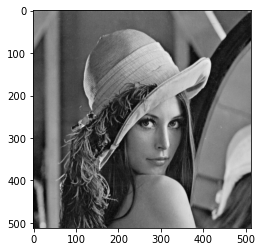

In [307]:
# Step 1
img = cv2.imread('lena.png')
img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
plt.imshow(img, cmap='gray')

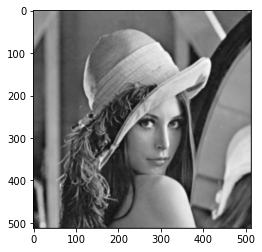

In [308]:
# Step 2
gaussian_3 = gaussian_filter(5)
normalized_img = convolve(img, gaussian_3)
plt.imshow(normalized_img, cmap='gray')

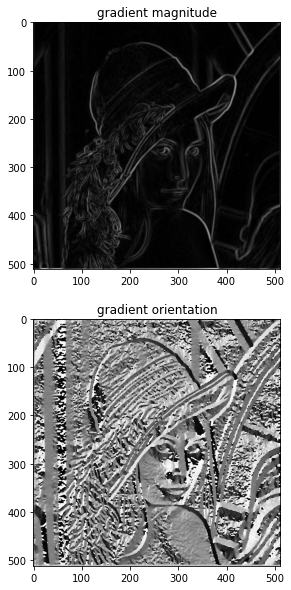

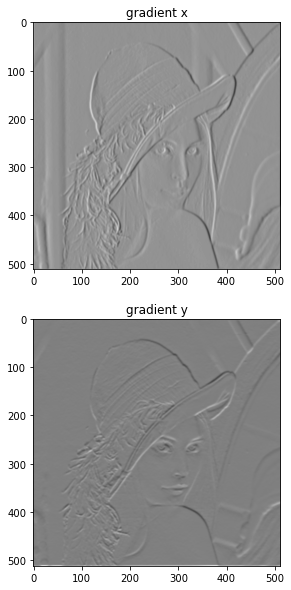

In [309]:
# Step 3
sobel_x = sobel_filter(5, 'x')
sobel_y = sobel_filter(5, 'y')
gradient_x = convolve(normalized_img, sobel_x)
gradient_y = convolve(normalized_img, sobel_y)
gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
gradient_magnitute = gradient_magnitude*255./np.max(gradient_magnitude)

gradient_orientation = np.arctan2(gradient_y, gradient_x)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('gradient magnitude')
plt.imshow(gradient_magnitude, cmap='gray')
plt.subplot(2,1,2)
plt.title('gradient orientation')
plt.imshow(gradient_orientation, cmap='gray')

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('gradient x')
plt.imshow(gradient_x, cmap='gray')
plt.subplot(2,1,2)
plt.title('gradient y')
plt.imshow(gradient_y, cmap='gray')


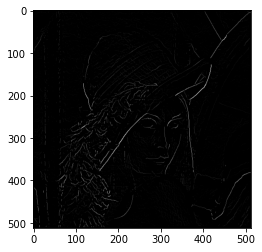

In [310]:
# Step 4
def non_maximum_suppression(gradient_magnitude, gradient_orientation):
    img_height, img_width = gradient_magnitude.shape
    suppressed_img = np.zeros((img_height, img_width))
    for i in range(1, img_height-1):
        for j in range(1, img_width-1):
            q = 255
            r = 255
            angle = gradient_orientation[i,j]
            if (0 <= angle < np.pi/8) or (7*np.pi/8 <= angle <= np.pi):
                q = gradient_magnitude[i, j+1]
                r = gradient_magnitude[i, j-1]
            elif (np.pi/8 <= angle < 3*np.pi/8):
                q = gradient_magnitude[i+1, j-1]
                r = gradient_magnitude[i-1, j+1]
            elif (3*np.pi/8 <= angle < 5*np.pi/8):
                q = gradient_magnitude[i+1, j]
                r = gradient_magnitude[i-1, j]
            elif (5*np.pi/8 <= angle < 7*np.pi/8):
                q = gradient_magnitude[i-1, j-1]
                r = gradient_magnitude[i+1, j+1]
            if (gradient_magnitude[i,j] >= q) and (gradient_magnitude[i,j] >= r):
                suppressed_img[i,j] = gradient_magnitude[i,j]
    return suppressed_img

suppressed_img = non_maximum_suppression(gradient_magnitude, gradient_orientation)
plt.imshow(suppressed_img, cmap='gray')

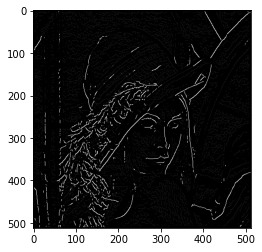

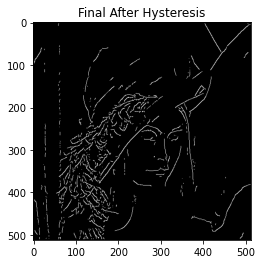

In [325]:
# Step 5
def double_threshold(suppressed_img, low_threshold_ratio, high_threshold_ratio):
    high_threshold = np.max(suppressed_img)*high_threshold_ratio
    low_threshold = high_threshold*low_threshold_ratio
    img_height, img_width = suppressed_img.shape
    result_img = np.zeros((img_height, img_width))
    weak = 25
    strong = 255
    strong_i, strong_j = np.where(suppressed_img >= high_threshold)
    weak_i, weak_j = np.where((suppressed_img <= high_threshold) & (suppressed_img >= low_threshold))
    result_img[strong_i, strong_j] = strong
    result_img[weak_i, weak_j] = weak
    return result_img, weak, strong

result_img, weak, strong = double_threshold(suppressed_img, 0.05, 0.15)
plt.imshow(result_img, cmap='gray')
plt.show()
def hysteresis(img, weak, strong=255):
    img_height, img_width = img.shape
    for i in range(1, img_height-1):
        for j in range(1, img_width-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

result_img = hysteresis(result_img, weak, strong)
plt.title("Final After Hysteresis")
plt.imshow(result_img, cmap='gray')


# Problem 2

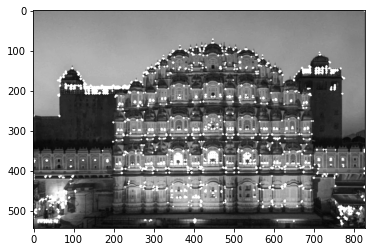

In [354]:
# This is short since I am using the utils function from the first cell of the notebook
img = cv2.imread('Harris.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def harris_corner(img, k=0.04, threshold=0.1, size=3):
    img_height, img_width = img.shape
    img = convolve(img, gaussian_filter(size=size))
  
    sobel_x = sobel_filter(size=size, d='x')
    sobel_y = sobel_filter(size=size, d='y')
 
    gradient_x = convolve(img, sobel_x)
    gradient_y = convolve(img, sobel_y)
  
    Ixx = np.multiply(gradient_x, gradient_x)
    Iyy = np.multiply(gradient_y, gradient_y)
    Ixy = np.multiply(gradient_x, gradient_y)

    gaussian = gaussian_filter(size=size)
    Sxx = convolve(Ixx, gaussian)
    Syy = convolve(Iyy, gaussian)
    Sxy = convolve(Ixy, gaussian)
    R = np.multiply(Sxx, Syy) - np.multiply(Sxy, Sxy) - k*np.square(Sxx + Syy)

    corner_img = img.copy()
    # cv2.normalize(corner_img, corner_img, 0, 1, cv2.NORM_MINMAX)
    # normalize to 0 and 1 without using cv2
    corner_img = corner_img - np.min(corner_img)
    corner_img = corner_img / np.max(corner_img)
    # cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX)
    R = R - np.min(R)
    R = R / np.max(R)
    loc = np.where(R >= threshold)
    for pt in zip(*loc[::-1]):
        cv2.circle(corner_img, pt, 2, (1), -1)
    return corner_img

corner_img = harris_corner(img, k=0.04, threshold=0.4, size=3)
plt.imshow(corner_img, cmap='gray')



key points are white

# Problem 2 using cv

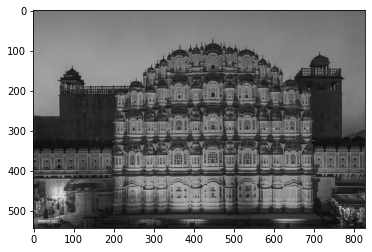

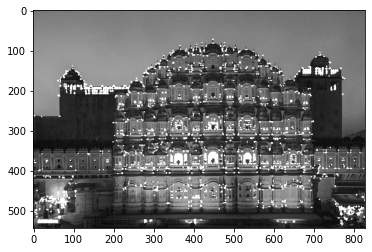

In [364]:
img = cv2.imread('Harris.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()
dst = cv2.cornerHarris(img,2,3,0.04)
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[255]
plt.imshow(img, cmap='gray')
plt.show()

Key points are white

# Problem 3

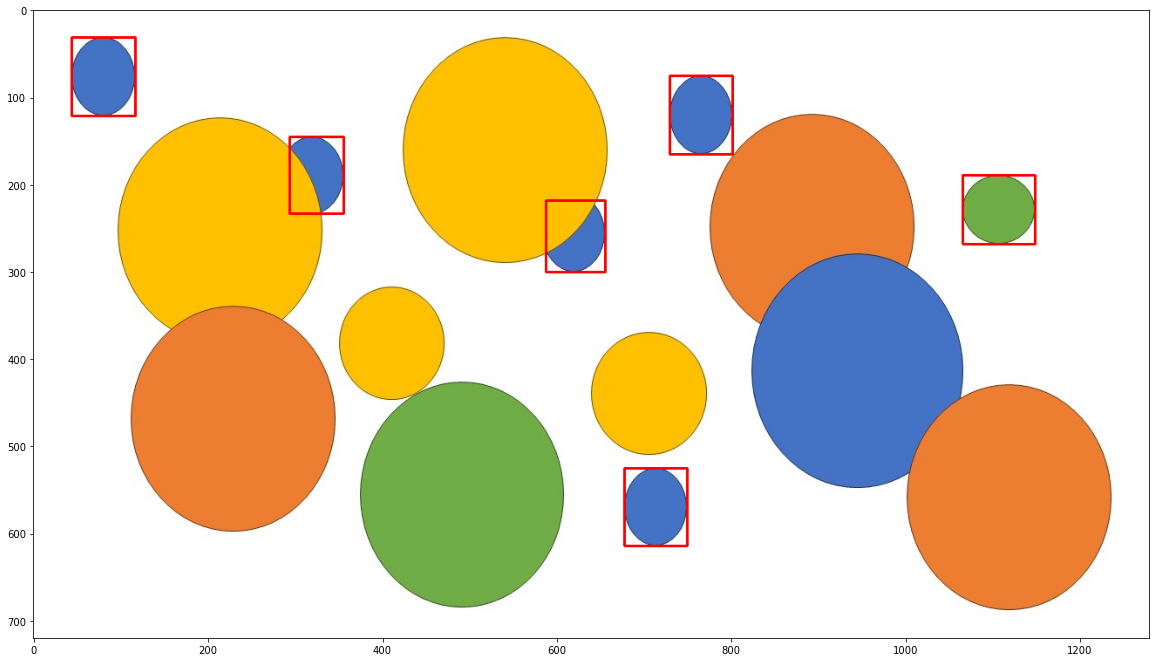


hyperparameters:
delta: 27
minArea: 2650
maxArea: 6000
Pass2Only: False

regions: 41


In [458]:
img = cv2.imread('img3.jpg')

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mser = cv2.MSER_create()
mser.setDelta(27)
# mser.setPass2Only(True)
mser.setMinArea(2650)
mser.setMaxArea(6000)

regions, _ = mser.detectRegions(img_gray)
img_copy = img.copy()
for p in regions:
    x, y, w, h = cv2.boundingRect(p)
    if h/w > 1.5: # outlier shape removal
        continue
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(img_copy)
plt.show()

print(f"""
hyperparameters:
delta: {mser.getDelta()}
minArea: {mser.getMinArea()}
maxArea: {mser.getMaxArea()}
Pass2Only: {mser.getPass2Only()}
""")
print(f"regions: {len(regions)}")


# Problem 4

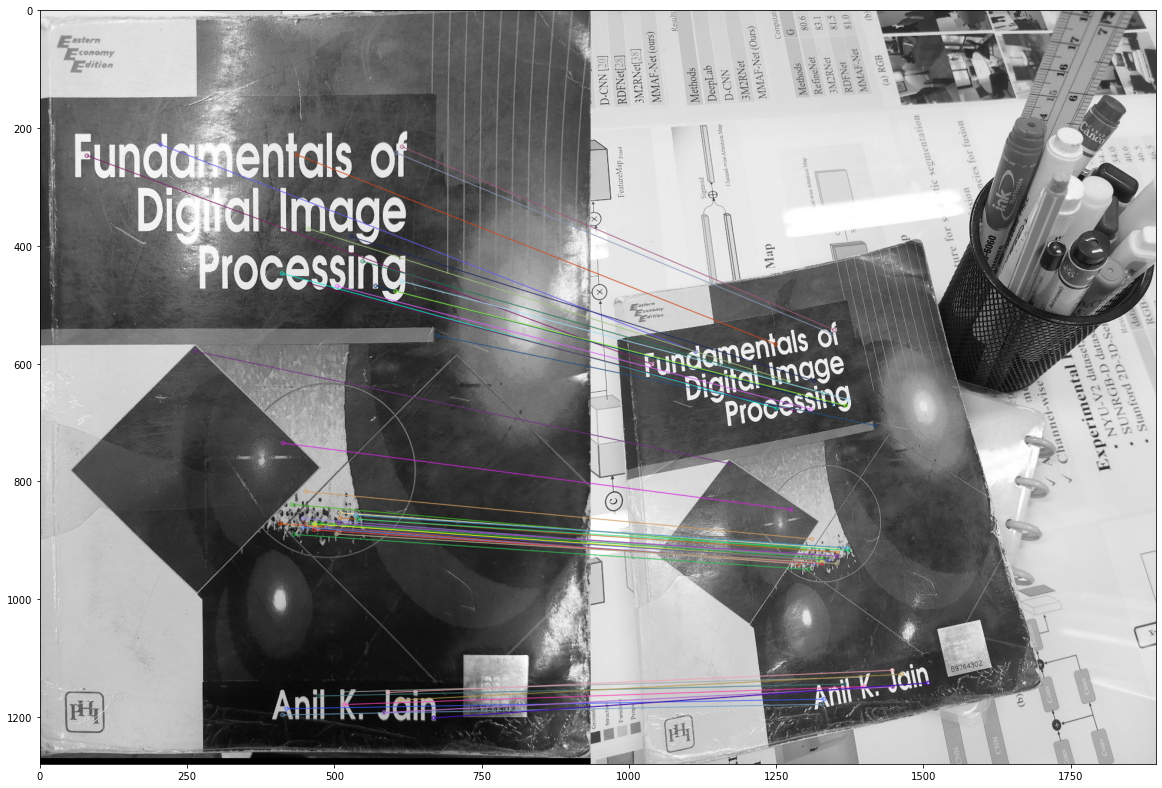

(<matplotlib.image.AxesImage at 0x7fefaca9ba00>, None)

In [352]:

template = cv2.imread('template.jpg')
img = cv2.imread('img4.jpg')
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
s = cv2.SIFT_create()
kp1, des1 = s.detectAndCompute(template,None)
kp2, des2 = s.detectAndCompute(img,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append([m])
img3 = cv2.drawMatchesKnn(template,kp1,img,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,20))
plt.imshow(img3),plt.show()